In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine("sqlite:///./app/connection/test.db", echo=False)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
session = SessionLocal()

In [2]:
from app.services.kor_value_service import KorValueService


kor_value_service = KorValueService(session)
value_list = kor_value_service.get_values(isDf=True)

In [3]:
# 밸류 지표 히스토그램
value_pivot = value_list.pivot(index="itemCd", columns="metrics", values="amt")
value_rank = value_pivot.rank(axis=0)

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for n, ax in enumerate(axes.flatten()):
    ax.hist(value_rank.iloc[:, n])
    ax.set_title(value_rank.columns[n], size=12)

In [ ]:
value_pivot.isna().sum()

In [7]:
# 랭킹을 구한 후 z-scoe로 정규화

from scipy.stats import zscore

value_rank_z = value_rank.apply(zscore, nan_policy="omit")

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 6), sharex=True, sharey=True)
for n, ax in enumerate(axes.flatten()):
    ax.hist(value_rank_z.iloc[:, n])
    ax.set_title(value_rank.columns[n], size=12)

In [2]:
# 멀티팩터
"""
퀄리티: 자기자본이익률(ROE), 매출총이익(GPA), 영업활동현금흐름(CFO)
밸류: PER, PBR, PSR, PCR, DY
모멘텀: 12개월 수익률, K-Ratio
섹터 중립화, 랭킹 후 Z-Score 변환
"""

from app.services.kor_fs_service import KorFsService
from app.services.kor_price_service import KorPriceService
from app.services.kor_sector_service import KorSectorService
from app.services.kor_ticker_service import KorTickerService
from app.services.kor_value_service import KorValueService

kor_ticker_service = KorTickerService(session)
kor_fs_service = KorFsService(session)
kor_value_service = KorValueService(session)
kor_price_service = KorPriceService(session)
kor_sector_service = KorSectorService(session)

ticker_list = kor_ticker_service.get_tickers(isDf=True)
fs_list = kor_fs_service.get_fs(
    "q", ["당기순이익", "매출총이익", "영업활동으로인한현금흐름", "자산", "자본"]
)
value_list = kor_value_service.get_values(isDf=True)
price_list = kor_price_service.get_year_price(is_df=True)
sector_list = kor_sector_service.get_sectors(is_df=True)

In [3]:
# 퀄리티
from app.services.portfolio_services.quality_portfolio_service import (
    QualityPortfolioService,
)

quality_protfolio_service = QualityPortfolioService(session)
fs_list = quality_protfolio_service._get_ttm()
fs_list_pivot = quality_protfolio_service._calc_quality(fs_list)

In [4]:
# 밸류
import numpy as np


value_list.loc[value_list["amt"] <= 0, "amt"] = np.nan
value_pivot = value_list.pivot(index="itemCd", columns="metrics", values="amt")

In [5]:
# 모멘텀
import pandas as pd
import statsmodels.api as sm

price_pivot = price_list.pivot(index="baseDt", columns="itemCd", values="closePrice")
ret_list = pd.DataFrame(
    data=(price_pivot.iloc[-1] / price_pivot.iloc[0]) - 1, columns=["12M"]
)


# 종목별 일간 수익률 계산
ret = price_pivot.pct_change().iloc[1:]
# 로그 누적 수익률
ret_cum = np.log(1 + ret).cumsum()

x = np.array(range(len(ret)))
k_ratio = {}  # 전종목 K-Ratio

for i in range(0, len(ticker_list)):
    ticker = ticker_list.loc[i, "itemCd"]
    try:
        y = ret_cum.loc[:, price_pivot.columns == ticker]
        # 선형회귀분석
        reg = sm.OLS(y, x).fit()
        res = float((reg.params / reg.bse).iloc[0])
    except:
        res = np.nan
    k_ratio[ticker] = res

k_radio_bind = pd.DataFrame.from_dict(k_ratio, orient="index").reset_index()
k_radio_bind.columns = ["itemCd", "k_ratio"]

In [6]:
# 퀄리티, 밸류, 모멘텀 데이터 합치기
data_bind = (
    ticker_list[["itemCd", "itemNm"]]
    .merge(
        sector_list[["cmpCd", "secNmKor"]],
        how="left",
        left_on="itemCd",
        right_on="cmpCd",
    )
    .merge(fs_list_pivot[["ROE", "GPA", "CFO"]], how="left", on="itemCd")
    .merge(value_pivot, how="left", on="itemCd")
    .merge(ret_list, how="left", on="itemCd")
    .merge(k_radio_bind, how="left", on="itemCd")
)

data_bind.loc[data_bind["secNmKor"].isnull(), "secNmKor"] = "기타"
data_bind = data_bind.drop(["cmpCd"], axis=1)

In [7]:
from scipy.stats import zscore


def col_clean(df, cutoff=0.01, asc=False):

    q_low = df.quantile(cutoff)
    q_hi = df.quantile(1 - cutoff)

    df_trim = df[(df > q_low) & (df < q_hi)]

    df_z_score = df_trim.rank(axis=0, ascending=asc).apply(zscore, nan_policy="omit")

    return df_z_score

In [8]:
# 섹터 별 그룹 묶기( 섹터별로 그룹이 묶인 부분에 함수를 적용하면 섹터중립화, 트림(극단치 제거), 랭킹의 z-score계산)
data_bind_group = data_bind.set_index(["itemCd", "secNmKor"]).groupby(
    "secNmKor", as_index=False
)

# 퀄리티(섹터 중립화된 수익성 순위의 Z-Score)
z_quality = (
    data_bind_group[["ROE", "GPA", "CFO"]]
    .apply(lambda x: col_clean(x, 0.01, False))
    .sum(axis=1, skipna=False)
    .to_frame("z_quality")
)

data_bind = data_bind.merge(z_quality, how="left", on=["itemCd", "secNmKor"])

In [9]:
# 벨류

# PBR, PCR,PER,PSR은 오름차순
value_1 = data_bind_group[["PBR", "PCR", "PER", "PSR"]].apply(
    lambda x: col_clean(x, 0.01, True)
)
# DY는 내림차순
value_2 = data_bind_group[["DY"]].apply(lambda x: col_clean(x, 0.01, False))

z_value = (
    value_1.merge(value_2, on=["itemCd", "secNmKor"])
    .sum(axis=1, skipna=False)
    .to_frame("z_value")
)
data_bind = data_bind.merge(z_value, how="left", on=["itemCd", "secNmKor"])

In [10]:
# 모멘텀
z_momentum = (
    data_bind_group[["12M", "k_ratio"]]
    .apply(lambda x: col_clean(x, 0.01, False))
    .sum(axis=1, skipna=False)
    .to_frame("z_momentum")
)
data_bind = data_bind.merge(z_momentum, how="left", on=["itemCd", "secNmKor"])

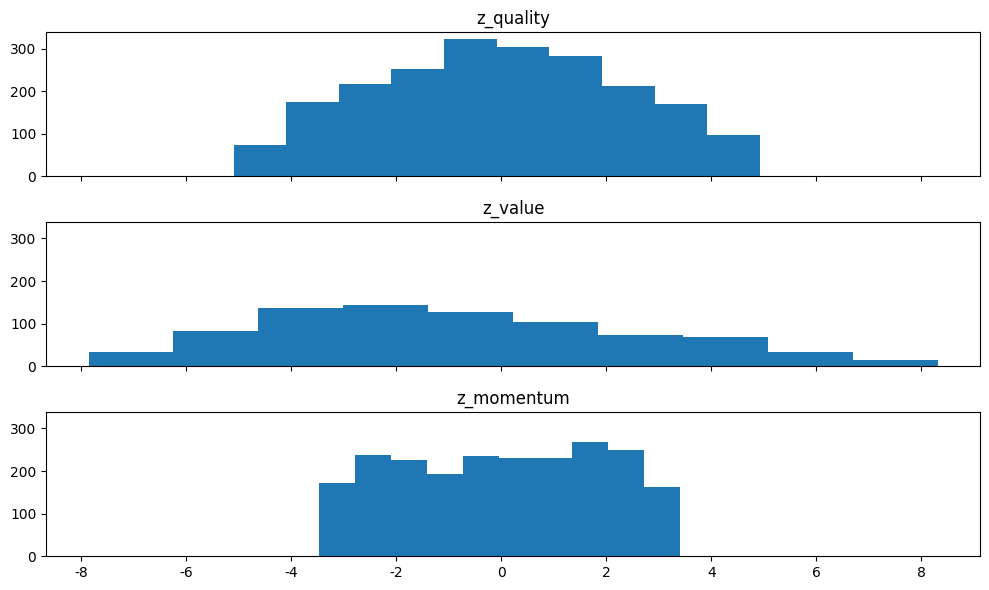

In [11]:
# 세개의 Z-Score 를 단순하게 합하면 안된다.
# 퀄리티 지표는 3개, 밸류는 5개 모멘텀은 2개를 이용하여 계산
# 지표를 많이 쓸수록 합이 많아지므로 Z-score가 넓게 퍼진다.

import matplotlib.pyplot as plt


# 분포 시각화
data_z = data_bind[["z_quality", "z_value", "z_momentum"]].copy()

plt.rc("axes", unicode_minus=False)
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True, sharey=True)
for n, ax in enumerate(axes.flatten()):
    ax.hist(data_z.iloc[:, n])
    ax.set_title(data_z.columns[n], size=12)
fig.tight_layout()

In [12]:
# 다시 z-score를 계산하여 분포를 비슷하게 맞춰준다.
# 분포를 완벽하게 맞추기위해 z-score를 몇번을 돌리기도 하는데 그럴필요는 없음
data_bind_final = (
    data_bind[["itemCd", "z_quality", "z_value", "z_momentum"]]
    .set_index("itemCd")
    .apply(zscore, nan_policy="omit")
)
data_bind_final.columns = ["quality", "value", "momentum"]

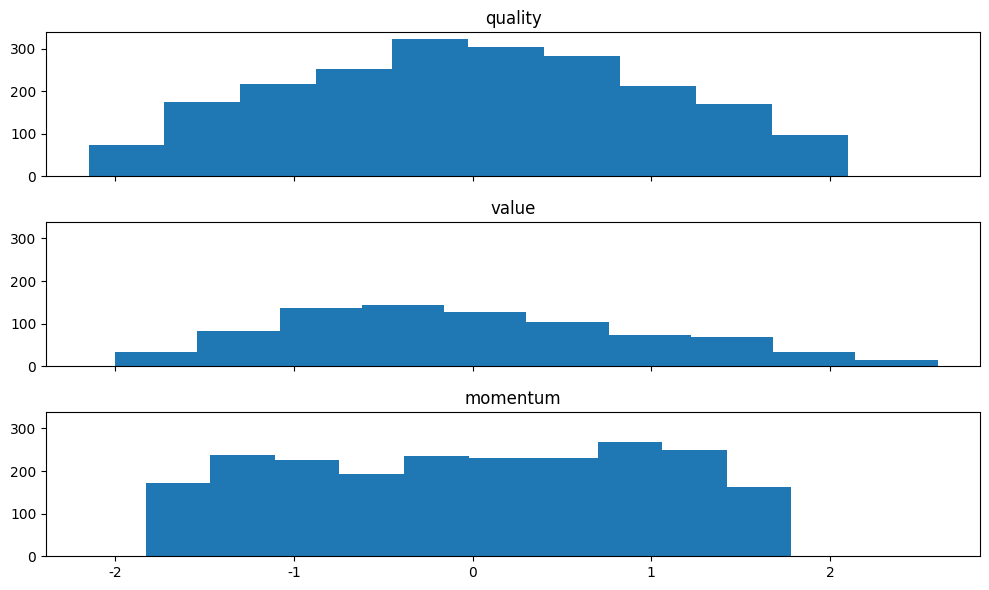

In [13]:
plt.rc("axes", unicode_minus=False)
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True, sharey=True)
for n, ax in enumerate(axes.flatten()):
    ax.hist(data_bind_final.iloc[:, n])
    ax.set_title(data_bind_final.columns[n], size=12)
fig.tight_layout()

In [14]:
# 최종포트폴리오
wts = [0.3, 0.3, 0.3]  # 동일비중
# 비중 곱해서 해응로 더하기
data_bind_final_sum = (data_bind_final * wts).sum(axis=1, skipna=False).to_frame()
# 컬럼명 변경
data_bind_final_sum.columns = ["qvm"]
port_qvm = data_bind.merge(data_bind_final_sum, on="itemCd")
# 20위 이내는 Y 아니면 N
port_qvm["invest"] = np.where(port_qvm["qvm"].rank() <= 20, "Y", "N")

In [ ]:
# 최근 적자기업 제외, 매출증가 등 다양한 전략을 추가할 수 도 있음.

port_qvm[port_qvm["invest"] == "Y"]["itemCd"].to_excel("model.xlsx", index=False)